In [3]:
# Importing Dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Connecting to database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Calculating the latest date (removing hard-coded aspects!)
tmp1 = session.query(func.max(Measurement.date)).all()
tmp2 = dt.datetime.strptime(tmp1[0][0], '%Y-%m-%d')
end_date = tmp2.strftime("%Y-%m-%d") # Latest date
tmp3 = tmp2 - relativedelta(years=1)
year_down = tmp3.strftime("%Y-%m-%d")
print(f"Latest Date: {end_date}, Year Removed: {year_down}")


Latest Date: 2017-08-23, Year Removed: 2016-08-23


# Exploratory Climate Analysis

366


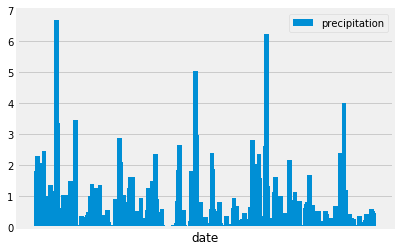

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Date needed: 8/23/2016
result = session.query(Measurement.date, func.max(Measurement.prcp).label("precipitation"))\
            .filter(Measurement.date >= year_down).group_by(Measurement.date).all()

print(len(result)) # Checking length
res_db = pd.DataFrame(result) # Converting result into dataframe
res_db = res_db.set_index('date') # Setting index

# Plotting precipitation data
plt.bar(res_db.index,res_db['precipitation'],width=5,label='precipitation')
blank = []
plt.xticks(blank,blank)
plt.xlabel('date')
plt.legend()
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
result_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_down).all()
result_q = pd.DataFrame(result_query)
result_q.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
print(len(session.query(Station.station).distinct().all()))

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
result_stat = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
result_stat

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
result_set = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()
result_set

#[(54.0, 85.0, 71.66378066378067)]

[(54.0, 85.0, 71.66378066378067)]

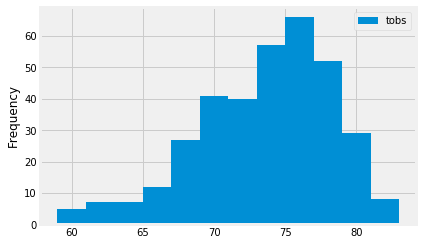

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_hist = session.query(Measurement.tobs).filter(Measurement.date > year_down,\
                                                     Measurement.station == 'USC00519281').all()

res_hist = pd.DataFrame(result_hist)
plt.hist(x=res_hist['tobs'],bins = 12,label="tobs")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#My Trip: 2017-06-11 to 2017-06-18 
my_trip = ['2016-06-11','2016-06-18']

print(calc_temps(my_trip[0],my_trip[1]))

[(69.0, 75.90384615384616, 81.0)]


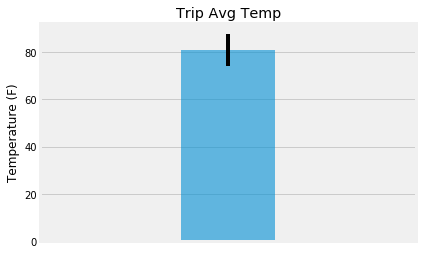

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps = calc_temps(my_trip[0],my_trip[1])
p2p = temps[0][1]-temps[0][0]
plt.bar(0,temps[0][2],width = 0.2,yerr=p2p,alpha = 0.6)
plt.xlim(-0.4,0.4)
blank = []
plt.xticks(blank,blank)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result_vacay = session.query(Station.station,Station.name,Station.latitude,Station.longitude,
                             Station.elevation,func.sum(Measurement.prcp).label("precipitation"))\
                .filter(Station.station == Measurement.station,
                        Measurement.date >= my_trip[0],Measurement.date < my_trip[1])\
                .group_by(Station.station).all()
    
vacay_db = pd.DataFrame(result_vacay).sort_values(by='precipitation', ascending=False).set_index('station')
vacay_db

,name,latitude,longitude,elevation,precipitation
station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.24
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.65
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.69
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.57
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.50
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.47
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.06
